# TreeView Simulations

In [1]:
import datetime
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import pandas as pd
import json
import seaborn

from pyeosim.atmosphere import LUT_from_file
from pyeosim.datasets import DATA_PATHS

def hist2d(ds, lims=(0,1), n_bins=20):
    h = np.empty((len(im.wavelength), n_bins))
    _im = ds
    for i in range(len(im.wavelength)):

        h[i,:] = np.histogram(_im.isel(wavelength=i).values.ravel(),
                              bins=np.linspace(lims[0],lims[1],n_bins+1))[0]
    return h

def read_atmos_meta(path):
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(atmos_path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T

# load and preprocess imagery 
fpath = DATA_PATHS['TEST_HSI_LARGE']
surface_reflectance = xarray.open_dataset(fpath).Reflectance
surface_reflectance = surface_reflectance.swap_dims({'band':'wavelength'})
surface_reflectance = surface_reflectance.sel(wavelength=slice(400,898)).astype(float)/10000
surface_reflectance = surface_reflectance.where(surface_reflectance <= 1, other=1)

## 2. Input Radiances

In [2]:
from pyeosim.spectral import TreeView_1, TreeView_2, Sentinel2VNIR, SuperDove, TreeView_3
cmap1=['blue', 'darkturquoise', 'limegreen', 'darkgreen', 'orange', 'deeppink', 'red','brown','grey', 'k']
cmap2=['blue', 'limegreen', 'darkgreen', 'orange', 'red','brown','grey', 'k']

In [3]:
atmos_path = 'atmospheres/atmospheres_2/'
atmos_meta = read_atmos_meta(atmos_path)
atmos = LUT_from_file(atmos_path, {
    'view_z': 0,
    'view_a': 0
})
# interpolate to a higher res lookup table
# atmos.LUT = atmos.LUT.interp(rho=np.linspace(.01,1, 100,), kwargs={'fill_value':'extrapolate'})
# atmos = Test6S()
# # generate Top of Atmosphere images
radiance = atmos.transform(surface_reflectance).compute()
radiance_ref = atmos.transform(xarray.ones_like(surface_reflectance))

Text(0.5, 1.0, 'NDVI | Atmosphere_1')

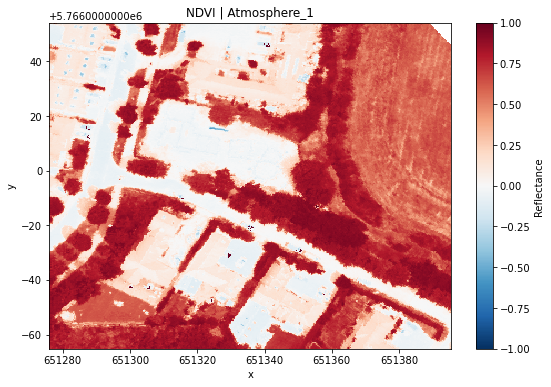

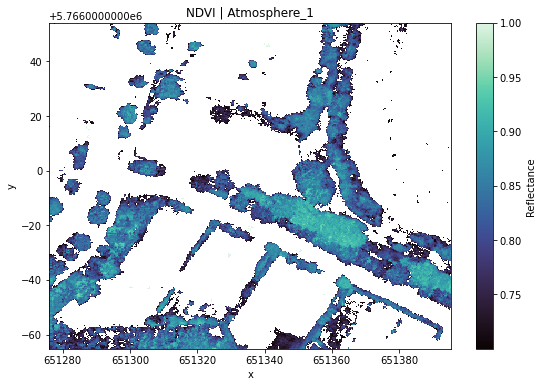

In [4]:
alt_bnames = ['Band_{}'.format(x) for x in range(8)]
BII = []
# for s in [TreeView_1(), TreeView_2(), Sentinel2VNIR(), SuperDove()]:
#     BII.append(s.transform(TOA))
    
for s in [TreeView_3()]:
    BII.append(s.transform(radiance, ))
    
BII = xarray.concat(BII, dim='sensor').assign_coords({'sensor':['TreeView_3']})
BII = BII.assign_coords({'band':alt_bnames})
df_whole_scene = pd.concat([BII.quantile(.025,['x','y','scenario']).to_pandas().T,
BII.quantile(.975,['x','y','scenario']).to_pandas().T], axis=1)
df_whole_scene.columns = ['min', 'max']
IR = surface_reflectance.sel(wavelength=827, method='nearest')
R = surface_reflectance.sel(wavelength=628, method='nearest')
NDVI = (IR - R) / (IR + R)
NDVI.plot(size=6)
plt.title('NDVI | Atmosphere_1')
NDVI.where(NDVI>.7).plot(cmap='mako', size=6)
plt.title('NDVI | Atmosphere_1')

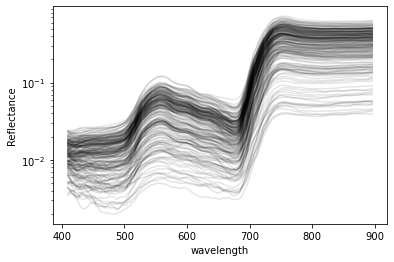

In [5]:
surface_reflectance.where(NDVI>.7).stack({'pix':['x','y']}).dropna('pix')[:, ::200].plot.line(x='wavelength',
                                                                             add_legend=False,
                                                                            color='k', alpha=.1)
plt.yscale('log')

Text(0.5, 1.0, 'TreeView')

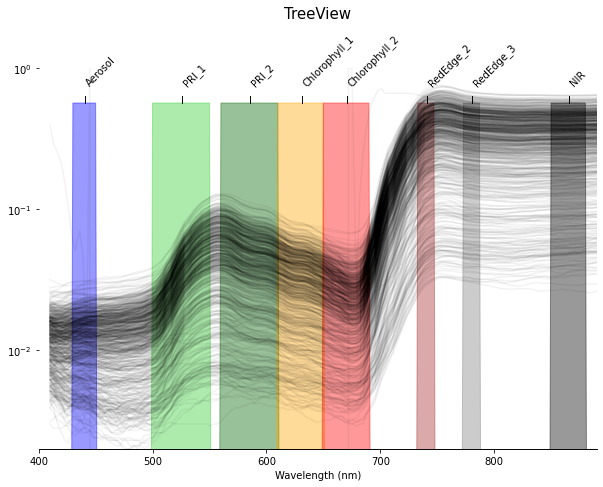

In [6]:
srf = TreeView_3()
ymax = .7
f, ax = plt.subplots(figsize=(10,7))


for n, c in zip(srf.band_names,
                cmap2):
#     srf.srfs[n].plot(c=c, label=n,)
    ax.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.4)
ax.set_ylim(.003,ymax*1.1)
ax.set_xlim(400,890)
# plt.legend()

ax.set_yticks([])
ax.set_ylabel('')

for wlen, name in zip(srf.band_wavelengths.values(), srf.band_names):
    ax.annotate(name, (wlen,ymax*1.05), rotation=45)
    ax.annotate('I', (wlen,ymax*1), rotation=0)

# Separate axis for vegetation spectra
ax2 = ax.twinx()
surface_reflectance.where(NDVI>.7).stack({'pix':['x','y']}).dropna('pix')[:, ::58].plot.line(x='wavelength',
                                                                             add_legend=False,
                                                                            color='k', alpha=.05)
ax2.set_ylabel('')
ax2.set_yscale('log')
ax2.yaxis.tick_left()
ax2.set_ylim(.002,1)
ax2.set_xlim(400,890)

# remove additional ticklines
ticks = ax2.yaxis.get_minor_ticks()
[x.set_visible(False) for x in ticks]

seaborn.despine(left=True)
ax.set_xlabel('Wavelength (nm)')
plt.title('TreeView', size=15, loc='center',pad=50)

In [7]:
mask = NDVI>.2
BII_2 = []
# for s in [TreeView_1(), TreeView_2(), Sentinel2VNIR(), SuperDove()]:
#     BII_2.append(s.transform(TOA).where(NDVI>.2))
    
for s in [TreeView_1(), TreeView_2(), TreeView_3()]:
    BII_2.append(s.transform(radiance).where(NDVI>.2))
    
# BII_2 = xarray.concat(BII_2, dim='sensor').assign_coords({'sensor':['TreeView_1',
#                                                                 'TreeView_2',
#                                                                 'Sentinel_2',
#                                                                 'Super_Dove']})

BII_2 = xarray.concat(BII_2, dim='sensor').assign_coords({'sensor':['TreeView_1',
                                                                    'TreeView_2',
                                                                    'TreeView_3']})


BII_2 = BII.assign_coords({'band':alt_bnames})
BII_2 = BII_2.where(mask)
df_veg_scene = pd.concat([BII_2.quantile(.025,['x','y','scenario']).to_pandas().T,
BII_2.quantile(.975,['x','y','scenario']).to_pandas().T], axis=1)
df_veg_scene.columns = ['min', 'max']

In [8]:
df_whole_scene['center'] = (df_whole_scene['max'] - df_whole_scene['min'])/2
df_veg_scene['center'] = (df_veg_scene['max'] - df_veg_scene['min'])/2

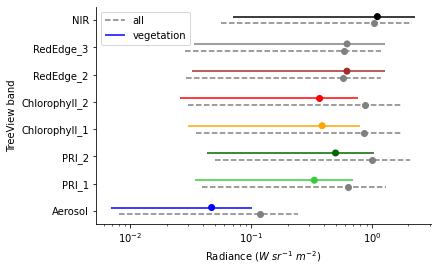

In [9]:
plt.hlines(np.arange(0,16,2), df_whole_scene['min'], df_whole_scene['max'],
           edgecolor='gray', linestyle='--', label='all')
plt.scatter(df_whole_scene['center'],np.arange(0,16,2), c='gray')
plt.hlines(np.arange(.5, 16.5, 2), df_veg_scene['min'], df_veg_scene['max'],
           edgecolor=cmap2, label='vegetation')
plt.scatter(df_veg_scene['center'],np.arange(0.5,16.5,2), c=cmap2)
plt.yticks(np.arange(.25, 16.25, 2), BII_2.band_name.values)
plt.xlabel(r'Radiance ($W~sr^{-1}~m^{-2}$)')
plt.ylabel('TreeView band')
plt.xscale('log')
plt.legend()
seaborn.despine()

## 5. Sensor specifications

In [10]:
import yaml
from pyeosim.sensor import TCMOS_test, TeledyneCMOS
sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)

def SNR(sim_name, quantiles=[.025, .975], NDVI_thresh=0.2, levels=100, repeats=10000):
    s1 = TCMOS_test(**sensor_configs[sim_name])
    mins = radiance.where(NDVI > .2).quantile(quantiles[0], ['x','y', 'scenario'], skipna=True).values
    maxs = radiance.where(NDVI > .2).quantile(quantiles[1], ['x','y', 'scenario'], skipna=True).values

    bands = radiance.wavelength.values
    bindex = np.arange(len(bands))
    radiance_tvals = np.zeros((len(bands),levels))
    for _min, _max, i in zip(mins, maxs, bindex):
        radiance_tvals[i, :] = np.linspace(_min, _max, levels)

    rad_tvals = xarray.DataArray(np.repeat(radiance_tvals[..., np.newaxis], repeats, axis=2),
                                      coords=[('wavelength', bands),
                                              ('x', np.arange(levels)),
                                              ('y', np.arange(repeats))])

    s1_snr = s1.fit_transform(rad_tvals)
    s1_snr = s1_snr.where(s1_snr < (2**12)-1)
    return (s1_snr.mean('y', skipna=False)/s1_snr.std('y', skipna=False)).fillna(-1)

def SNR_PAN(sim_name, quantiles=[.025, .975], NDVI_thresh=0.2, levels=100, repeats=10000, bins=4):
    s1 = TCMOS_test(**sensor_configs[sim_name])
    mins = radiance.where(NDVI > .2).quantile(quantiles[0], ['x','y', 'scenario'], skipna=True).values
    maxs = radiance.where(NDVI > .2).quantile(quantiles[1], ['x','y', 'scenario'], skipna=True).values

    bands = radiance.wavelength.values
    bindex = np.arange(len(bands))
    radiance_tvals = np.zeros((len(bands),levels))
    for _min, _max, i in zip(mins, maxs, bindex):
        radiance_tvals[i, :] = np.linspace(_min, _max, levels)

    rad_tvals = xarray.DataArray(np.repeat(radiance_tvals[..., np.newaxis], repeats, axis=2),
                                      coords=[('wavelength', bands),
                                              ('x', np.arange(levels)),
                                              ('y', np.arange(repeats)),])

    s1_snr = s1.fit_transform(rad_tvals)
    s1_snr = s1_snr.where(s1_snr < (2**12)-1)
    # additional step to do binning
    s1_snr = s1_snr.groupby(xarray.DataArray(np.tile(np.arange(repeats/bins).astype(int), bins), dims=['y'])).sum()
    return (s1_snr.mean('group', skipna=False)/s1_snr.std('group', skipna=False)).fillna(-1)

### MSI Channel simulations

In [11]:
# tv1_16 = SNR('TreeView_1_MSI_16')
# tv1_32 = SNR('TreeView_1_MSI_32')
# tv2_16 = SNR('TreeView_2_MSI_16')
# tv2_32 = SNR('TreeView_2_MSI_32')
# tv3_16 = SNR('TreeView_3_MSI_16')
tv3_32 = SNR('TreeView_3_MSI_32')
tv3_64 = SNR_PAN('TreeView_3_PAN_64', repeats=40000)

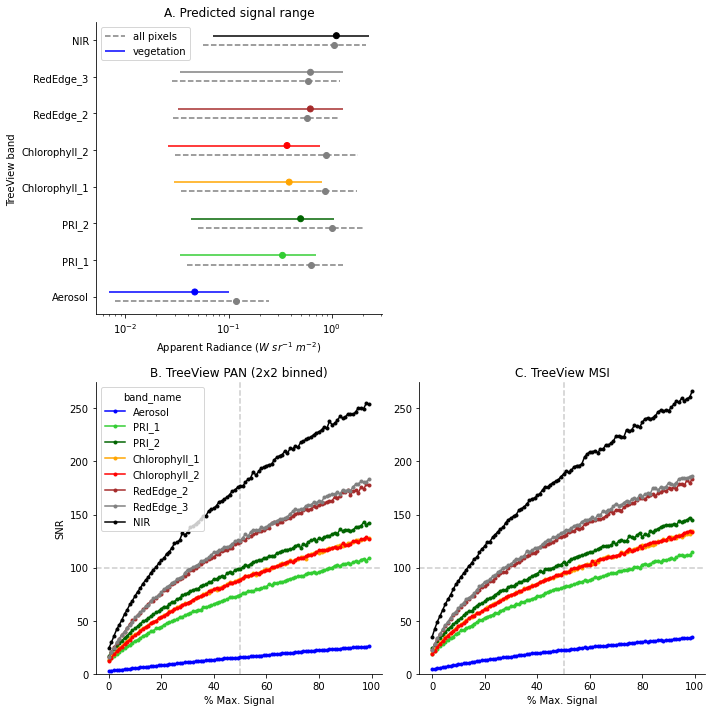

In [12]:
f, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flat
# common params
for _ax in ax[2:]:
    _ax.axhline(100, linestyle='--', c='k', alpha=.2)
    _ax.axvline(50, linestyle='--', c='k', alpha=.2)
    _ax.set_ylim(0, 275)
    _ax.set_prop_cycle(color=cmap2)

ax[1].set_visible(False)

# subplot 2
tv3_64.plot.line(hue='band_name', marker='.', ax=ax[2])
ax[2].set_title('B. TreeView PAN (2x2 binned)')
ax[2].set_ylabel('SNR')
ax[2].set_xlabel('% Max. Signal')

# subplot 3
tv3_32.plot.line(hue='band', marker='.', ax=ax[3],add_legend=False)
ax[3].set_title('C. TreeView MSI')
ax[3].set_xlabel('% Max. Signal')

#subplot 0
ax[0].hlines(np.arange(0,16,2), df_whole_scene['min'], df_whole_scene['max'],
           edgecolor='gray', linestyle='--', label='all pixels')
ax[0].scatter(df_whole_scene['center'],np.arange(0,16,2), c='gray')
ax[0].hlines(np.arange(.5, 16.5, 2), df_veg_scene['min'], df_veg_scene['max'],
           edgecolor=cmap2, label='vegetation')
ax[0].scatter(df_veg_scene['center'],np.arange(0.5,16.5,2), c=cmap2)
ax[0].set_yticks(np.arange(.25, 16.25, 2))
ax[0].set_yticklabels(BII_2.band_name.values)
ax[0].set_xlabel(r'Apparent Radiance ($W~sr^{-1}~m^{-2}$)')
ax[0].set_ylabel('TreeView band')
ax[0].set_title('A. Predicted signal range')
ax[0].set_xscale('log')
ax[0].legend()
# plt.legend()
seaborn.despine()
plt.tight_layout()

In [13]:
import colorcet

In [14]:
sim_name = 'TreeView_3_MSI_32'
_sensor = TeledyneCMOS(**sensor_configs[sim_name])
sim1 = _sensor.fit_transform(radiance)
# simulate an image
veg_mask_2m = NDVI.interp(x=sim1.x.values, y=sim1.y.values)
veg_mask_2m = veg_mask_2m > .2

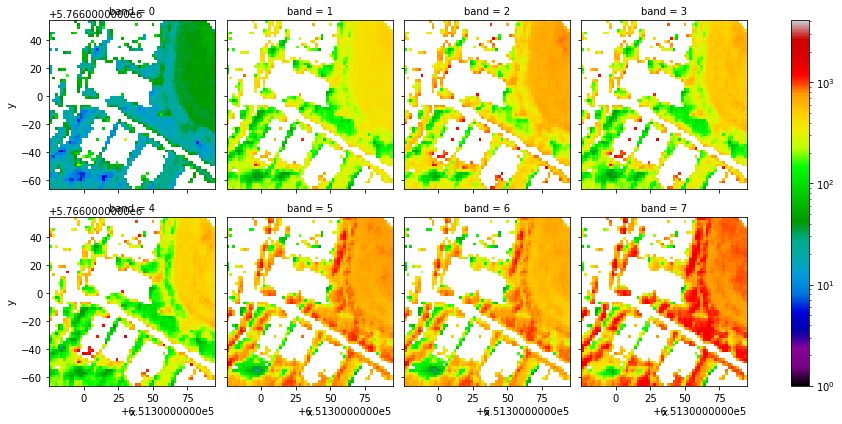

In [15]:
sim1.where(veg_mask_2m).isel(scenario=6).plot(col='band',
                                             col_wrap=4,
                                             norm=LogNorm(vmin=1, vmax=((2**12)-1)),
                                             cmap='nipy_spectral')

In [16]:
sim_name = 'TreeView_3_PAN_64'
_sensor = TeledyneCMOS(**sensor_configs[sim_name])
sim2 = _sensor.fit_transform(radiance)
# perform binning

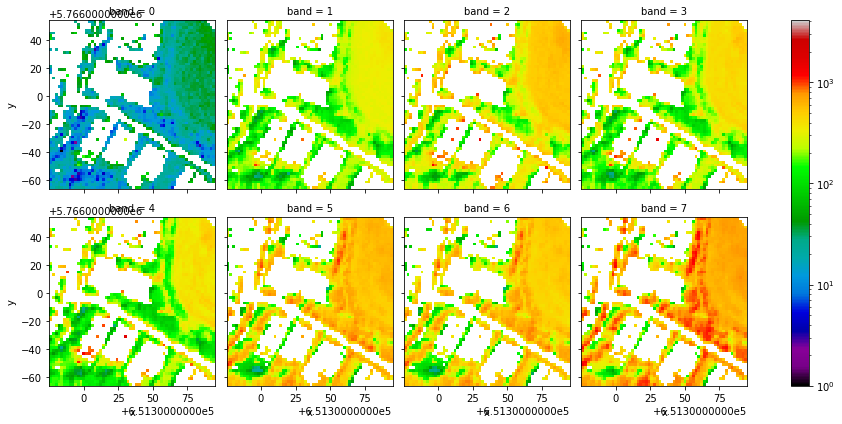

In [17]:
sim2.where(veg_mask_2m).isel(scenario=6).plot(col='band',
                                             col_wrap=4,
                                             norm=LogNorm(vmin=1, vmax=((2**12)-1)),
                                             cmap='nipy_spectral')

In [18]:
ndvi = (sim1.isel(band=7) - sim1.isel(band=4)) / (sim1.isel(band=7) + sim1.isel(band=4))
pri = (sim1.isel(band=1) - sim1.isel(band=2)) / (sim1.isel(band=1) + sim1.isel(band=2))

In [19]:
import copy
from pyeosim.plot import rgb
import matplotlib

cmap = copy.copy(matplotlib.cm.get_cmap('mako'))

cmap.set_bad(color='k')

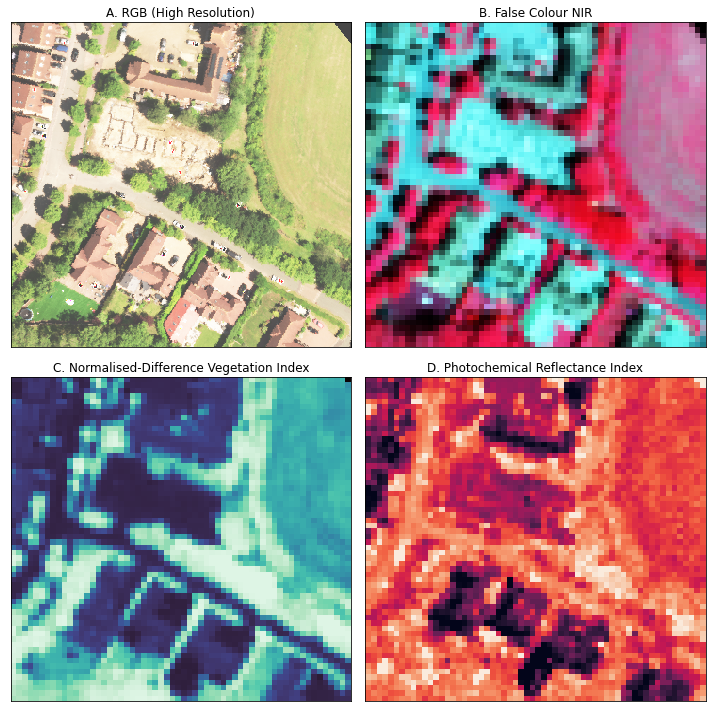

In [20]:
f, axs = plt.subplots(2,2, figsize=(10,10))
axs=axs.flat
pri.isel(scenario=6).plot(cmap='rocket',
                                             robust=True,
                                             ax=axs[3],
                                             add_colorbar=False)
ndvi.isel(scenario=6).plot(cmap=cmap,
                                              robust=True,
                                              ax=axs[2],
                                              add_colorbar=False)
rgb(sim1.isel(scenario=6, band=[7, 4, 2]), ax=axs[1])
rgb(xarray.open_dataset(fpath).Reflectance.isel(band=[70, 40, 20]),ax=axs[0])

for a, name in zip(axs, ['A. RGB (High Resolution)',
                         'B. False Colour NIR',
                         'C. Normalised-Difference Vegetation Index',
                         'D. Photochemical Reflectance Index']):
    a.set_yticks([])
    a.set_xticks([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_title(name)

plt.tight_layout()


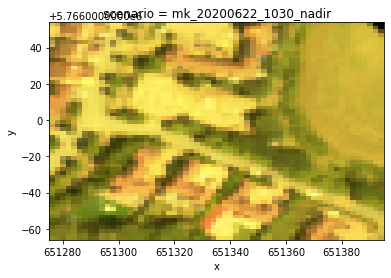

In [21]:
rgb(sim1.isel(scenario=6, band=[3, 1, 0]))